This notebook is a tutorial for performing integration between scATAC Metacells and scRNA Metacells when multiome data is not available. The integration is performed between Metacell gene expression and Metacell gene scores using linear transport

# Imports

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [5]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. 

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

The datasets below are Anndata objects for the CD34 multiome data generated for use in the SEACells manuscript



## RNA

In [6]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells/cd34_multiome_rna_with_labels.h5ad -O data/cd34_multiome_rna_with_labels.h5ad
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells/cd34_multiome_atac_with_labels.h5ad -O data/cd34_multiome_atac_with_labels.h5ad

In [12]:
# Load the data using scanpy

# This object contains raw counts and the results of SEACells
rna_ad = sc.read(f'data/cd34_multiome_rna_with_labels.h5ad')

from SEACells.core import summarize_by_SEACell
rna_meta_ad = summarize_by_SEACell(rna_ad, SEACells_label='SEACell')

  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/seacells/lib/python3.8/site-packages/SEACells/core.py:558: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  meta_ad = sc.AnnData(csr_matrix(summ_matrix))


In [13]:
rna_meta_ad.obs['celltype'] = rna_ad.obs.groupby('SEACell').apply(lambda x: pd.Series(x['celltype']).mode())#%%

In [18]:
# Normalize and log transform the data
sc.pp.normalize_per_cell(rna_meta_ad, counts_per_cell_after=10000)
log_transform(rna_meta_ad)

# Select highly variable genes
sc.pp.highly_variable_genes(rna_meta_ad)

# Perform PCA and UMAPs
sc.tl.pca(rna_meta_ad, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(rna_meta_ad, n_neighbors=5)
sc.tl.umap(rna_meta_ad)

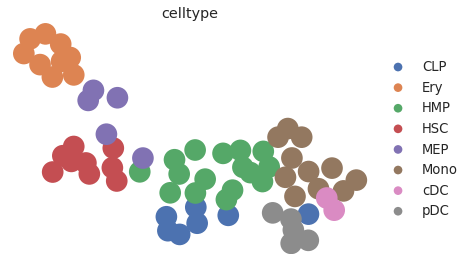

In [19]:
%matplotlib inline
# Plot cell-types for reference
sc.pl.scatter(rna_meta_ad, basis='umap', color='celltype', frameon=False)

# ATAC-seq gene scores

We use the gene scores derived from ArchR aggregated by SEACell.

In [21]:
atac_ad = sc.read(f'data/cd34_multiome_atac_with_labels.h5ad')

In [22]:
# Aggregate gene scores
genescores = pd.DataFrame(atac_ad.obsm['GeneScores'])
genescores.columns = rna_meta_ad.var_names
genescores.index = atac_ad.obs_names

genescores = genescores.join(atac_ad.obs['SEACell']).groupby('SEACell').sum()

In [ ]:
# Create Anndata
import anndata
atac_meta_ad = anndata.AnnData(genescores)
atac_meta_ad.obs = atac_ad.obs.loc[atac_meta_ad.obs_names]

In [24]:
from scipy.sparse import csr_matrix
atac_meta_ad.X = csr_matrix(atac_meta_ad.X)

In [27]:
# Normalize the ATAC counts analogous to RNA counts
sc.pp.normalize_per_cell(atac_meta_ad, counts_per_cell_after=10000)
log_transform(atac_meta_ad)

# Compute PCA using the highly variable genes from RNA 
hvg = atac_meta_ad.var_names.intersection(rna_meta_ad.var_names[rna_meta_ad.var['highly_variable']])
atac_hvg = pd.Series(False, index=atac_meta_ad.var_names)
atac_hvg[hvg] = True
atac_meta_ad.var['highly_variable'] = atac_hvg
sc.tl.pca(atac_meta_ad, n_comps=50)

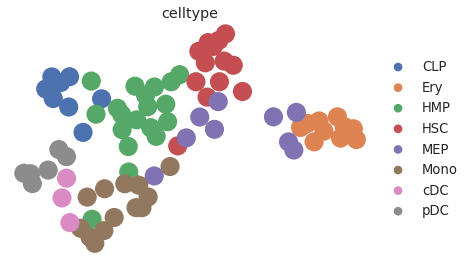

In [28]:
# ATAC gene scores umap
sc.pp.neighbors(atac_meta_ad, use_rep='X_pca', n_neighbors=5)
sc.tl.umap(atac_meta_ad)
sc.pl.scatter(atac_meta_ad, basis='umap', color='celltype', frameon=False)

In [45]:
# Annotate the Anndata objects based on their dataset
atac_meta_ad.obs['Dataset'] = 'ATAC'
rna_meta_ad.obs['Dataset'] = 'RNA'

# Create a combined Anndata object only including hvg
hvg = atac_meta_ad.var_names[atac_meta_ad.var['highly_variable']].intersection(rna_meta_ad.var_names)
comb_ad = rna_meta_ad[:, hvg].concatenate(atac_meta_ad[:, hvg])

/usr/local/anaconda3/envs/seacells/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [49]:
# PCA 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30)
comb_ad.obsm['X_pca'] = svd.fit_transform(comb_ad.X)

# Integration using linear transport

Inputs are

- xs, Matrix of "source" RNA expression levels from scRNA-seq
- xt, Matrix of "target" gene activities calcualated from ATAC-seq peak accessibility


The number of metacells can be variable between the two modalities but the number of columns should remain the same. We will use the jointly computed PCs as input for integration

Optional paramters

- ws: Vector of weights representing the size of each cluster/metacell from RNA
- wt: Same as above but for ATAC
- rho: Float in range [0,1] representing whether the final transformation should be closer to RNA distribution (0) or ATAC distribution (1). Default value is 1.
- reg: Small float to make sure covariance matrices are invertible

In [50]:
xs = comb_ad[comb_ad.obs['Dataset'] == 'RNA'].obsm['X_pca']
xt = comb_ad[comb_ad.obs['Dataset'] == 'ATAC'].obsm['X_pca']

In [51]:
from SEACells.domainadapt import LinearOT

model = LinearOT(rho=0)

xs_transformed, xt_transformed = model.fit_transform(xs, xt)

In [52]:
comb_ad.obsm['X_pca_transformed'] = pd.DataFrame(xs_transformed).append(pd.DataFrame(xt_transformed)).values

/var/folders/x3/p87l8d1n5qvcxb8hjggq4cg80000gq/T/ipykernel_84957/2157489645.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comb_ad.obsm['X_pca_transformed'] = pd.DataFrame(xs_transformed).append(pd.DataFrame(xt_transformed)).values


## Integration result

In [60]:
sc.pp.neighbors(comb_ad, use_rep='X_pca_transformed', n_neighbors=5)

In [61]:
sc.tl.umap(comb_ad)

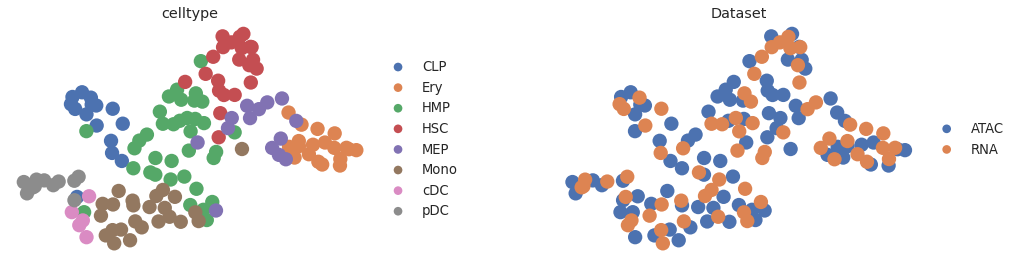

In [63]:
sc.pl.scatter(comb_ad, basis='umap', color=['celltype', 'Dataset'], frameon=False)

# Mapping ATAC SEACells to RNA SEACellss

In [64]:
# Mapping ATAC SEACells to RNA SEACellss
rna_PCs = pd.DataFrame(xs_transformed)
atac_PCs = pd.DataFrame(xt_transformed)

rna_PCs.index = rna_meta_ad.obs_names
atac_PCs.index = atac_meta_ad.obs_names


In [65]:
def compute_distances(df1, df2):
    result = pd.DataFrame(np.zeros((df1.shape[0],df2.shape[0]))).set_index(df1.index)
    result.columns = df2.index

    for mc1, row1 in df1.iterrows():
        for mc2, row2 in df2.iterrows():
            result.loc[mc1, mc2] = np.sqrt(((row1-row2)**2).sum())

    return result

def get_match_ranks(t,k=5):
    """
    Compute mutually ranked metacell matches.
    """
    arr = t.values.T
    ind = np.argsort(arr, axis=0)[:k].T

    df = pd.DataFrame(t.columns.values[ind])
    df.index = t.index
    
    return df

def MNN(rna_PCs, atac_PCs, k=3):
    """
    Construct a mapping between RNA and ATAC SEACells, if an RNA SEACell and 
    ATAC SEACell are mutually in each others' k-nearest neighbors.
    
    Nearest neighbors are computed based on distance in transformed PC space,
    following domain adaption by optimal transport.
    """
    
    # Compute distances between PCs in each data set
    dists = compute_distances(rna_PCs, atac_PCs)
    
    # Find the top k nearest neighbors in each row of the distance matrix
    r1 = get_match_ranks(dists, k)
    r2 = get_match_ranks(dists.T, k)
    # Add edges between samples if they appear in each others top-ranks 

    edges = []
    for index, row in r1.iterrows():
        for nbr in row.values:
            if index in r2.loc[nbr].values:
                edges.append((index, nbr))

    edges = pd.DataFrame(edges)
    edges.columns = ['RNA', 'ATAC']
    return edges

In [66]:
mapping = MNN(rna_PCs, atac_PCs)
mapping.head()

,RNA,ATAC
0,cd34_multiome_rep2#CATTCCTCACCCACAG-1,cd34_multiome_rep1#GGCGGTAAGTAGCGGG-1
1,cd34_multiome_rep2#CATTCCTCACCCACAG-1,cd34_multiome_rep1#TACAGCTAGACCATAC-1
2,cd34_multiome_rep2#CAATCGCCACGTAAGG-1,cd34_multiome_rep2#TAACCTAAGGATTGAG-1
3,cd34_multiome_rep1#CCAAGTTAGGACCTCA-1,cd34_multiome_rep1#ATGGCTGTCAATGTCA-1
4,cd34_multiome_rep1#CCAAGTTAGGACCTCA-1,cd34_multiome_rep1#ATTGCACAGTCAATTG-1
